# <center>Exercise 5 Recommend System</center>

**Objectives**
- Create Recommend System based on Userbased Collaborative Filtering and Item-based Collaborative Filtering.

**Data Source:**  The Professor

In [1]:
import numpy as np
import pandas as pd
import time

import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

In [2]:
import sys

if not sys.warnoptions:
    import warnings
    warnings.simplefilter("ignore")

## 1 DATA UNDERSTANDING

In [3]:
# Import movie data
movies = pd.read_csv('movie.csv')
movies

,movieId,title,genres
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,2,Jumanji (1995),Adventure|Children|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance
4,5,Father of the Bride Part II (1995),Comedy
...,...,...,...
27273,131254,Kein Bund für's Leben (2007),Comedy
27274,131256,"Feuer, Eis & Dosenbier (2002)",Comedy
27275,131258,The Pirates (2014),Adventure
27276,131260,Rentun Ruusu (2001),(no genres listed)


In [4]:
# Only keep movie id and title
movies = movies.loc[:,['movieId','title']]
movies

,movieId,title
0,1,Toy Story (1995)
1,2,Jumanji (1995)
2,3,Grumpier Old Men (1995)
3,4,Waiting to Exhale (1995)
4,5,Father of the Bride Part II (1995)
...,...,...
27273,131254,Kein Bund für's Leben (2007)
27274,131256,"Feuer, Eis & Dosenbier (2002)"
27275,131258,The Pirates (2014)
27276,131260,Rentun Ruusu (2001)


In [5]:
# Import movie rating data
ratings = pd.read_csv('rating.csv')
ratings

,userId,movieId,rating,timestamp
0,1,2,3.5,2005-04-02 23:53:47
1,1,29,3.5,2005-04-02 23:31:16
2,1,32,3.5,2005-04-02 23:33:39
3,1,47,3.5,2005-04-02 23:32:07
4,1,50,3.5,2005-04-02 23:29:40
...,...,...,...,...
20000258,138493,68954,4.5,2009-11-13 15:42:00
20000259,138493,69526,4.5,2009-12-03 18:31:48
20000260,138493,69644,3.0,2009-12-07 18:10:57
20000261,138493,70286,5.0,2009-11-13 15:42:24


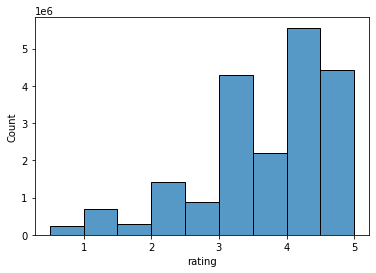

In [6]:
# Plot movie rating score distribution
sns.histplot(data=ratings, x='rating', binwidth=0.5)

plt.show()

## 2 DATA PREPARATION

In [7]:
# Merge ratings and movies tables together on “movieId” column

data = pd.merge(ratings, movies, on='movieId')
data

,userId,movieId,rating,timestamp,title
0,1,2,3.5,2005-04-02 23:53:47,Jumanji (1995)
1,5,2,3.0,1996-12-25 15:26:09,Jumanji (1995)
2,13,2,3.0,1996-11-27 08:19:02,Jumanji (1995)
3,29,2,3.0,1996-06-23 20:36:14,Jumanji (1995)
4,34,2,3.0,1996-10-28 13:29:44,Jumanji (1995)
...,...,...,...,...,...
20000258,138301,121017,3.5,2015-01-06 15:34:39,The Gentleman from Epsom (1962)
20000259,138301,121019,4.5,2015-01-06 15:36:46,The Great Spy Chase (1964)
20000260,138301,121021,4.5,2015-01-06 15:38:07,Taxi for Tobruk (1961)
20000261,138406,110167,4.5,2014-03-30 12:55:27,"Judge and the Assassin, The (Juge et l'assassi..."


In [8]:
# In order to learn recommendation system in a simple way, use 1 million of samples in data

data_1m = data.iloc[:1000000,:]
data_1m

,userId,movieId,rating,timestamp,title
0,1,2,3.5,2005-04-02 23:53:47,Jumanji (1995)
1,5,2,3.0,1996-12-25 15:26:09,Jumanji (1995)
2,13,2,3.0,1996-11-27 08:19:02,Jumanji (1995)
3,29,2,3.0,1996-06-23 20:36:14,Jumanji (1995)
4,34,2,3.0,1996-10-28 13:29:44,Jumanji (1995)
...,...,...,...,...,...
999995,90990,1198,3.5,2013-12-29 00:56:33,Raiders of the Lost Ark (Indiana Jones and the...
999996,90991,1198,5.0,2001-12-04 22:30:47,Raiders of the Lost Ark (Indiana Jones and the...
999997,90995,1198,5.0,2000-01-07 04:03:17,Raiders of the Lost Ark (Indiana Jones and the...
999998,90997,1198,3.0,2000-04-26 02:17:35,Raiders of the Lost Ark (Indiana Jones and the...


## 3 MODELING AND EVALUATION

In [9]:
# Setup a pivot table in order to make rows are users and columns are movies, and values are rating.

pivot_table = data_1m.pivot_table(index=['userId'], columns=['title'], values=['rating'])
pivot_table

rating                      \
title  2001: A Space Odyssey (1968) Blade Runner (1982)   
userId                                                    
1                               3.5                 4.0   
2                               5.0                 5.0   
3                               5.0                 5.0   
4                               NaN                 NaN   
5                               NaN                 NaN   
...                             ...                 ...   
138488                          NaN                 NaN   
138489                          NaN                 NaN   
138490                          NaN                 NaN   
138492                          NaN                 NaN   
138493                          NaN                 NaN   

                                                                        \
title  City of Lost Children, The (Cité des enfants perdus, La) (1995)   
userId                                                                   
1                                                     3.5                
2                                                     NaN                
3                                                     NaN                
4                                                     NaN                
5                                                     NaN                
...                                                   ...                
138488                                                NaN                
138489                                                4.0                
138490                                                NaN                
138492                                                NaN                
138493                                                NaN                

                                                         \
title  Clerks (1994) Die Hard (1988) Dragonheart (1996)   
userId                                                    
1                4.0             4.0                3.0   
2                NaN             NaN                NaN   
3                5.0             NaN                NaN   
4                NaN             NaN                NaN   
5                NaN             5.0                NaN   
...              ...             ...                ...   
138488           NaN             NaN                NaN   
138489           NaN             NaN                NaN   
138490           NaN             NaN                NaN   
138492           NaN             NaN                NaN   
138493           NaN             NaN                NaN   

                                                                          \
title  E.T. the Extra-Terrestrial (1982) Escape to Witch Mountain (1975)   
userId                                                                     
1                                    4.0                             3.5   
2                                    NaN                             NaN   
3                                    5.0                             NaN   
4                                    NaN                             NaN   
5                                    5.0                             NaN   
...                                  ...                             ...   
138488                               NaN                             NaN   
138489                               NaN                             NaN   
138490                               NaN                             NaN   
138492                               NaN                             NaN   
138493                               3.5                             NaN   

                                    \
title  Fish Called Wanda, A (1988)   
userId                               
1                              4.0   
2                              NaN   
3                              4.0   
4                              NaN   
5      

### 3.1 Item-based Collaborative Filtering

In [10]:
# Compute correlation
start = time.time()
movie_Dragonheart = pivot_table[("rating","Dragonheart (1996)")]
similarity_with_other_movies = pivot_table.corrwith(movie_Dragonheart, axis=0)

# Find correlation between "Dragonheart(1996)" and other movies
similarity_with_other_movies = similarity_with_other_movies.sort_values(ascending=False)

end = time.time()
print('Time consume: ', end-start)
similarity_with_other_movies.head()

Time consume:  0.06895661354064941


        title                          
rating  Dragonheart (1996)                 1.000000
        Jumanji (1995)                     0.431915
        Mask, The (1994)                   0.289748
        Rob Roy (1995)                     0.261300
        Escape to Witch Mountain (1975)    0.259679
dtype: float64

>Results:
>- The most similar movie of “Dragonheart (1996)” is “Jumanji”.
>- Which means if a user likes “Dragonheart (1996)”, there will be a high probability that this user also likes “Jumanji”.

### 3.2 User-based Collaborative Filtering

In [11]:
# Compute correlation
start = time.time()
user1 = pivot_table.loc[1]
similarity_with_other_users1 = pivot_table.corrwith(user1, axis=1)

# Find correlation between user[1] with other users
similarity_with_other_users1 = similarity_with_other_users1.sort_values(ascending=False)

end = time.time()
print('Time consume: ', end-start)
similarity_with_other_users1.head()

Time consume:  27.956618785858154


userId
5763     1.0
69319    1.0
27715    1.0
69010    1.0
27499    1.0
dtype: float64

In [12]:
# Select users that correlation less than 1 but greater than 0.8 as target users.

similarity_with_other_users1[(similarity_with_other_users1 < 1) & (similarity_with_other_users1 > 0.8)]

userId
36056     1.0
35957     1.0
123873    1.0
44217     1.0
123871    1.0
         ... 
118001    0.8
23273     0.8
77144     0.8
28091     0.8
124431    0.8
Length: 7059, dtype: float64

>Results:
>- The most similar users of user 1 are listed above. 
>- Which means these users would like the same movies and rank them the same.
>- In this case, we can recommend movies to them based on user 1's preference movie list.

### 3.3 Evaluation

- Item-based Collaborative Filtering computing time consuming is 0.05972409248352051.
- Whereas User-based Collaborative Filtering computing time consuming is 11.529365301132202, much slower than that of Item-based Collaborative Filtering.

## Exercise on 10 million samples

### Data Preparation

In [13]:
# Take 10 million of samples in data

data_10m = data.iloc[:10000000,:]
data_10m

,userId,movieId,rating,timestamp,title
0,1,2,3.5,2005-04-02 23:53:47,Jumanji (1995)
1,5,2,3.0,1996-12-25 15:26:09,Jumanji (1995)
2,13,2,3.0,1996-11-27 08:19:02,Jumanji (1995)
3,29,2,3.0,1996-06-23 20:36:14,Jumanji (1995)
4,34,2,3.0,1996-10-28 13:29:44,Jumanji (1995)
...,...,...,...,...,...
9999995,58742,728,5.0,1996-12-14 18:07:12,Cold Comfort Farm (1995)
9999996,58769,728,5.0,1997-04-09 10:17:21,Cold Comfort Farm (1995)
9999997,58774,728,4.0,1997-06-25 00:13:34,Cold Comfort Farm (1995)
9999998,58882,728,4.0,1997-04-20 23:17:55,Cold Comfort Farm (1995)


In [14]:
# Setup a pivot table in order to make rows are users and columns are movies, and values are rating.

pivot_table2 = data_10m.pivot_table(index=['userId'], columns=['title'], values=['rating'])
pivot_table2

rating                                    \
title  *batteries not included (1987) 10 Things I Hate About You (1999)   
userId                                                                    
1                                 NaN                               NaN   
2                                 NaN                               NaN   
3                                 NaN                               NaN   
4                                 NaN                               NaN   
5                                 NaN                               NaN   
...                               ...                               ...   
138489                            NaN                               NaN   
138490                            NaN                               NaN   
138491                            NaN                               NaN   
138492                            NaN                               NaN   
138493                            NaN                               NaN   

                                                                \
title  10,000 BC (2008) 100 Girls (2000) 101 Dalmatians (1996)   
userId                                                           
1                   NaN              NaN                   NaN   
2                   NaN              NaN                   NaN   
3                   NaN              NaN                   NaN   
4                   NaN              NaN                   NaN   
5                   NaN              NaN                   NaN   
...                 ...              ...                   ...   
138489              NaN              NaN                   NaN   
138490              NaN              NaN                   NaN   
138491              NaN              NaN                   NaN   
138492              NaN              NaN                   NaN   
138493              NaN              NaN                   3.0   

                                                                     \
title  102 Dalmatians (2000) 13 Ghosts (1960) 13 Going on 30 (2004)   
userId                                                                
1                        NaN              NaN                   NaN   
2                        NaN              NaN                   NaN   
3                        NaN              NaN                   NaN   
4                        NaN              NaN                   NaN   
5                        NaN              NaN                   NaN   
...                      ...              ...                   ...   
138489                   NaN              NaN                   NaN   
138490                   NaN              NaN                   NaN   
138491                   NaN              NaN                   NaN   
138492                   NaN              NaN                   NaN   
138493                   NaN              NaN                   NaN   

                                     ...               \
title  1408 (2007) 16 Blocks (2006)  ... X-Men (2000)   
userId                               ...                
1              NaN              NaN  ...          NaN   
2              NaN              NaN  ...          NaN   
3              NaN              NaN  ...          NaN   
4              NaN              NaN  ...          NaN   
5              NaN              NaN  ...          NaN   
...            ...              ...  ...          ...   
138489         NaN              NaN  ...          NaN   
138490         NaN              NaN  ...          NaN   
138491         NaN              NaN  ...          NaN   
138492         NaN              NaN  ...          NaN   
138493         NaN              NaN  ...          4.5   

                                                                     \
title  X-Men Origins: Wolverine (2009) X-Men: The Last Stand (2006)   
userId                                                                
1                                  NaN          

### Item-based Collaborative Filtering - Toy Story (1995)

In [15]:
# Compute correlation
start = time.time()
movie_toyStory = pivot_table2[("rating","Toy Story (1995)")]
similarity_with_other_movies2 = pivot_table2.corrwith(movie_toyStory, axis=0)

# Find correlation between "Toy Story (1995)" and other movies
similarity_with_other_movies2 = similarity_with_other_movies2.sort_values(ascending=False)

end = time.time()
print('Time consume: ', end-start)
similarity_with_other_movies2.head()

Time consume:  1.1514708995819092


        title               
rating  Toy Story (1995)        1.000000
        Dark Ride (2006)        0.766758
        Toy Story 2 (1999)      0.739854
        Bug's Life, A (1998)    0.528696
        Finding Nemo (2003)     0.504607
dtype: float64

>Results:
>- The most similar movie of “Toy Story (1995)” is “Dark Ride (2006), Toy Story 2 (1999)”.
>- Which means if a user likes “Toy Story (1995)”, there will be a high probability that this user also likes “Dark Ride (2006), Toy Story 2 (1999)”.

### User-based Collaborative Filtering - User 2

In [16]:
# Compute correlation
start = time.time()
user2 = pivot_table2.loc[2]
similarity_with_other_users2 = pivot_table2.corrwith(user2, axis=1)

# Find correlation between user[2] with other users
similarity_with_other_users2 = similarity_with_other_users2.sort_values(ascending=False)

end = time.time()
print('Time consume: ', end-start)
similarity_with_other_users2.head()

Time consume:  36.45112919807434


userId
106447    1.0
108378    1.0
50881     1.0
49395     1.0
117314    1.0
dtype: float64

In [17]:
# Select users that correlation less than 1 but greater than 0.8 as target users.

similarity_with_other_users2[(similarity_with_other_users2 < 1) & (similarity_with_other_users2 > 0.8)]

userId
106700    1.0
37012     1.0
68865     1.0
6871      1.0
36691     1.0
         ... 
37598     0.8
122935    0.8
82179     0.8
99083     0.8
89904     0.8
Length: 6860, dtype: float64

>Results:
>- The most similar users of user 2 are listed above.
>- Which means these users would like the same movies and rank them the same.
>- In this case, we can recommend movies to them based on user 2’s movie list.